### Librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Conexión SQL
# ==============================================================================
import psycopg2 as ps

import seaborn as sns

#Biblioteca para estimar modelos estadísticos y realizar pruebas estadísticas.
# ==============================================================================
import statsmodels.formula.api as sfm 

from sklearn.preprocessing import PolynomialFeatures 

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn import linear_model

### Conexión SQL

In [2]:
conexion = ps.connect(host="codbview.c21jlbp5d5qr.us-east-1.rds.amazonaws.com", database="codb", user="sgonzalez", password="AdarlaToda100%",port="5432")

In [3]:
# Creamos el cursor con el objeto conexion
cur = conexion.cursor()

# Ejecutamos una consulta
sql = """
select ipc, activations, radio, tv, ooh, pop, digital_performance, eventos_alto_bitacora, eventos_bajo_bitacora,
eventos_medio_bitacora 
from sal_indicators_in sa 
where sales_channel = 'Digital'
"""

consulta = cur.execute(sql)

data = cur.fetchall()

In [12]:
df = pd.DataFrame(data,columns=['ipc','activations','radio','tv','ooh','pop','digital_performance','eventos_alto_bitacora','eventos_bajo_bitacora','eventos_medio_bitacora'])

df['ipc']=df['ipc'].astype('float')
df['eventos_alto_bitacora']=df['eventos_alto_bitacora'].astype('float')
df['eventos_bajo_bitacora']=df['eventos_bajo_bitacora'].astype('float')
df['eventos_medio_bitacora']=df['eventos_medio_bitacora'].astype('float')

df = df.fillna(0)
#df = df.dropna()

df.head()

,ipc,activations,radio,tv,ooh,pop,digital_performance,eventos_alto_bitacora,eventos_bajo_bitacora,eventos_medio_bitacora
0,1.60,9566,41687525,771166,0,2884220.0,365633245,0.00,0.0,1.00
1,1.56,8031,57231920,95440163,79373000,8170000.0,422084086,0.75,0.0,0.25
2,1.51,7260,116243171,194643334,0,0.0,429255030,1.00,0.0,0.00
3,1.95,12262,117469351,366792554,0,34349575.0,426026002,0.30,0.1,0.60
4,3.30,7940,131734088,320208915,0,34349575.0,372675824,1.00,0.0,0.00


### Distribución de los Datos

<Figure size 2160x1440 with 0 Axes>

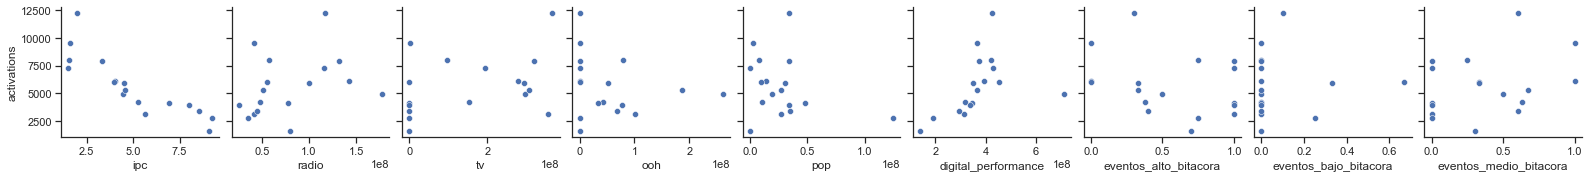

In [5]:
plt.figure(figsize=(30,20)) 
sns.set_theme(style="ticks")

sns.pairplot(df, x_vars=['ipc','radio','tv','ooh','pop','digital_performance','eventos_alto_bitacora','eventos_bajo_bitacora','eventos_medio_bitacora'], y_vars=['activations']) 

plt.show()

### Correlaciones

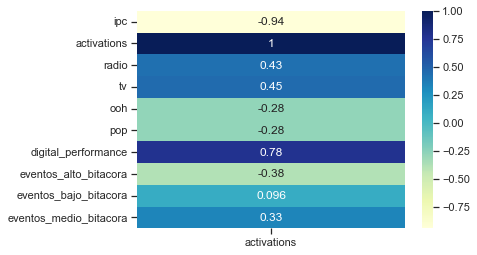

In [6]:
corrMatrix_1 = df.corr(method ='spearman')[['activations']]


sns.heatmap(corrMatrix_1, annot=True,cmap="YlGnBu")

plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled = scaler.fit_transform(df)

df = pd.DataFrame(scaled,columns=['ipc','activations','radio','tv','ooh','pop','digital_performance','eventos_alto_bitacora','eventos_bajo_bitacora','eventos_medio_bitacora'])

df = df.fillna(0)
#df = df.dropna()

df.head()

,ipc,activations,radio,tv,ooh,pop,digital_performance,eventos_alto_bitacora,eventos_bajo_bitacora,eventos_medio_bitacora
0,-1.311166,1.478317,-0.870890,-1.066161,-0.736316,-0.857172,-0.004035,-1.531394,-0.452709,1.889798
1,-1.326841,0.893458,-0.508717,-0.418478,0.365472,-0.669777,0.480201,0.536961,-0.452709,-0.343281
2,-1.346435,0.599696,0.866201,0.260227,-0.736316,-0.959425,0.541714,1.226413,-0.452709,-1.087641
3,-1.174010,2.505534,0.894770,1.437996,-0.736316,0.258356,0.514015,-0.704052,0.117369,0.698822
4,-0.644979,0.858786,1.227128,1.119291,-0.736316,0.258356,0.056376,1.226413,-0.452709,-1.087641


### Omitir Variables 
De acuerdo a su correlación

In [14]:
#del df['eventos_medio_bitacora']
#del df['ipc']
del df['eventos_alto_bitacora']
del df['radio']
#del df['ooh']
del df['pop']
del df['tv']
#del df['rotacion']
#del df['comisiones']
#del df['digital_performance']
del df['eventos_bajo_bitacora']

### Regresión Lineal

In [15]:
# División de los datos en train y test
# ==============================================================================
X = df.drop(columns='activations',axis=1)
y = df['activations']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

#Prediction using test set 
y_pred = lin_reg.predict(X_test)
mae=metrics.mean_absolute_error(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred)

# Printing the metrics
print('R2 square:',metrics.r2_score(y_test, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

print('explained_variance:',metrics.explained_variance_score(y_test, y_pred))
print('')

print('')
model=sm.OLS(y,X).fit() 

model.summary()

R2 square: 0.8130902681611716
MAE:  0.39863852200807887
MSE:  0.18870281242327325

explained_variance: 0.8377619333262053




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            activations   R-squared (uncentered):                   0.797
Model:                            OLS   Adj. R-squared (uncentered):              0.735
Method:                 Least Squares   F-statistic:                              12.77
Date:                Thu, 14 Jul 2022   Prob (F-statistic):                    0.000194
Time:                        13:09:12   Log-Likelihood:                         -10.560
No. Observations:                  17   AIC:                                      29.12
Df Residuals:                      13   BIC:                                      32.45
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
ipc                       -0.7409      0.191     -3.886      0.002      -1.153      -0.329
ooh                       -0.2756      0.179     -1.543      0.147      -0.661       0.110
digital_performance        0.1349      0.221      0.611      0.551      -0.342       0.612
eventos_medio_bitacora     0.1059      0.132      0.805      0.435      -0.178       0.390
==============================================================================
Omnibus:                        7.991   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                4.861
Skew:                           1.072   Prob(JB):                       0.0880
Kurtosis:                       4.506   Cond. No.                         3.37
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
print(X.columns)
print("")
print('w = ' + str(lin_reg.coef_) + ', b = ' + str(lin_reg.intercept_))

Index(['ipc', 'ooh', 'digital_performance', 'eventos_medio_bitacora'], dtype='object')

w = [[-0.87717684 -0.20481917  0.03663105  0.05462192]], b = [-0.03713501]


In [10]:
model.params

ipc                       -162.151512
ooh                         -0.000024
digital_performance          0.000019
eventos_medio_bitacora    1807.059090
dtype: float64

\begin{align}
\dot{activations} = \ ipc(-9.02177196e+02) + ooh(-7.46197036e-06) + digitalPerformance(8.24695670e-07) + eventosMedioBitacora(4.26842200e+02) + 9988.62616688\\
\end{align}

### Modelo Regresión Activaciones con Recarga y con PAC

In [11]:
# Creamos el cursor con el objeto conexion
cur2 = conexion.cursor()

# Ejecutamos una consulta
sql2 = """
select ipc, activations, activations_w_topups, activations_pacs, radio, tv, ooh, pop, 
digital_performance, eventos_alto_bitacora, eventos_bajo_bitacora,
eventos_medio_bitacora 
from sal_indicators_in sa 
where sales_channel = 'Digital'
"""

consulta2 = cur2.execute(sql2)

data2 = cur2.fetchall()

In [12]:
df2 = pd.DataFrame(data2,columns=['ipc','activations','activations_w_topups','activations_pacs','radio','tv','ooh','pop','digital_performance','eventos_alto_bitacora','eventos_bajo_bitacora','eventos_medio_bitacora'])

df2['ipc']=df2['ipc'].astype('float')
df2['eventos_alto_bitacora']=df2['eventos_alto_bitacora'].astype('float')
df2['eventos_bajo_bitacora']=df2['eventos_bajo_bitacora'].astype('float')
df2['eventos_medio_bitacora']=df2['eventos_medio_bitacora'].astype('float')


df2 = df2.fillna(0)
#df = df.dropna()

df2.head()

,ipc,activations,activations_w_topups,activations_pacs,radio,tv,ooh,pop,digital_performance,eventos_alto_bitacora,eventos_bajo_bitacora,eventos_medio_bitacora
0,1.60,9566,5461,5364,41687525,771166,0,2884220.0,365633245,0.00,0.0,1.00
1,1.56,8031,5929,5882,57231920,95440163,79373000,8170000.0,422084086,0.75,0.0,0.25
2,1.51,7260,5538,5443,116243171,194643334,0,0.0,429255030,1.00,0.0,0.00
3,1.95,12262,6898,6746,117469351,366792554,0,34349575.0,426026002,0.30,0.1,0.60
4,3.30,7940,6098,6037,131734088,320208915,0,34349575.0,372675824,1.00,0.0,0.00


##### Recargas

In [13]:
# División de los datos en train y test
# ==============================================================================

X = df2[['activations']]
y = df2['activations_w_topups']


X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

#Prediction using test set 
y_pred = lin_reg.predict(X_test)
mae=metrics.mean_absolute_error(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred)

# Printing the metrics
print('R2 square:',metrics.r2_score(y_test, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

print('explained_variance:',metrics.explained_variance_score(y_test, y_pred))
print('')

print('')
model=sm.OLS(y,X).fit() 

model.summary()

R2 square: 0.853147352987986
MAE:  337.80660013391923
MSE:  214754.99806117878

explained_variance: 0.8923871161890939




<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     activations_w_topups   R-squared (uncentered):                   0.983
Model:                              OLS   Adj. R-squared (uncentered):              0.982
Method:                   Least Squares   F-statistic:                              917.9
Date:                  Thu, 07 Jul 2022   Prob (F-statistic):                    1.47e-15
Time:                          09:08:22   Log-Likelihood:                         -131.60
No. Observations:                    17   AIC:                                      265.2
Df Residuals:                        16   BIC:                                      266.0
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
activations     0.6733      0.022     30.296      0.000       0.626       0.720
==============================================================================
Omnibus:                       10.991   Durbin-Watson:                   2.336
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                7.742
Skew:                          -1.477   Prob(JB):                       0.0208
Kurtosis:                       4.484   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
print(X.columns)
print("")
print('w = ' + str(lin_reg.coef_) + ', b = ' + str(lin_reg.intercept_))

Index(['activations'], dtype='object')

w = [[0.60161264]], b = [585.79483114]


\begin{align}
\dot{activations W topups} = \ activations(0.60161264) + 585.79483114\\
\end{align}

##### PACS

In [15]:
# División de los datos en train y test
# ==============================================================================
X = df2[['activations_w_topups']]
y = df2['activations_pacs']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

#Prediction using test set 
y_pred = lin_reg.predict(X_test)
mae=metrics.mean_absolute_error(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred)

# Printing the metrics
print('R2 square:',metrics.r2_score(y_test, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

print('explained_variance:',metrics.explained_variance_score(y_test, y_pred))
print('')

print('')
model=sm.OLS(y,X).fit() 

model.summary()

R2 square: 0.9988820244058619
MAE:  31.862596084051802
MSE:  1539.0647350908107

explained_variance: 0.9994458758480491




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       activations_pacs   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.101e+05
Date:                Thu, 07 Jul 2022   Prob (F-statistic):                    3.89e-32
Time:                        09:08:24   Log-Likelihood:                         -90.777
No. Observations:                  17   AIC:                                      183.6
Df Residuals:                      16   BIC:                                      184.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
activations_w_topups     0.9841      0.003    331.871      0.000       0.978       0.990
==============================================================================
Omnibus:                       10.094   Durbin-Watson:                   2.537
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                6.879
Skew:                          -1.413   Prob(JB):                       0.0321
Kurtosis:                       4.315   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
print(X.columns)
print("")
print('w = ' + str(lin_reg.coef_) + ', b = ' + str(lin_reg.intercept_))

Index(['activations_w_topups'], dtype='object')

w = [[0.98654761]], b = [-15.53303693]


\begin{align}
\dot{activations PACs} = \ activationsWtopups(0.98654761) - 15.53303693\\
\end{align}